In [10]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pathlib


import torch

print(torch.__version__)

In [9]:
#set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU disponibile. Utilizzo della GPU.")
else:
    device = torch.device("cpu")
    print("GPU non disponibile. Utilizzo della CPU.")

print("Dispositivo attualmente in uso:", device)

GPU non disponibile. Utilizzo della CPU.
Dispositivo attualmente in uso: cpu


In [12]:
# To analyze the dataset

def explore_dataset(dataset_path):
    # Initialize a dictionary to count file extensions
    extension_counts = {}
    # Initialize a list to contain the first ten files
    sample_files = []

    # Traverse the dataset
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            # Construct the full path of the file
            file_path = os.path.join(root, file)

            # Get the file extension
            _, file_extension = os.path.splitext(file)

            # Update the extension count
            extension_counts[file_extension] = extension_counts.get(file_extension, 0) + 1

            # Add the file to the list of the first ten if it is not a directory
            if not os.path.isdir(file_path):
                sample_files.append(file_path)

    # Print statistics
    print(f"Total number of files: {sum(extension_counts.values())}")
    print("Count per extension:")
    for extension, count in extension_counts.items():
        print(f"{extension}: {count}")

    # Print information about the first ten files
    print("\nFirst ten files:")
    for i, file_path in enumerate(sample_files[:10], 1):
        print(f"{i}. {file_path}")


In [ ]:
#TODO normalization and color standardization e poi regolare la dimensione per il modello HoverNet di segmentazione

Color standardization and resizing

In [13]:
# Define transformations (resizing, normalization and color standardization)
IMG_SIZE = 128
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
folder = '../BreaKHis_v1/BreaKHis_v1/histology_slides/breast'
folder_path= pathlib.Path(folder)
# Execute the function to explore the dataset
explore_dataset(folder)

Total number of files: 7923
Count per extension:
.txt: 10
.sh: 1
.py: 2
.SOB: 1
.png: 7909

First ten files:
1. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/README.txt
2. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/count_files.sh
3. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/lobular_carcinoma.stat.txt
4. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/ductal_carcinoma.stat.txt
5. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/process_db_stat.py
6. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/papillary_carcinoma.stat.txt
7. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/mucinous_carcinoma.stat.txt
8. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/ductal_carcinoma.stat.txt.SOB
9. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobular_carcinoma/SOB_M_LC_14-12204/200X/SOB_M_LC-14-12204-200-037.png
10. ../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/lobula

In [19]:
# Create a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_files = []

        # Traverse the directory tree
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Filter only files with supported extensions
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    # Create the full path and add to the list
                    self.image_files.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]

        # Check if the file is a valid image
        if not os.path.isfile(img_name) or not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            raise FileNotFoundError(f"Invalid file: {img_name}")

        image = Image.open(img_name).convert("RGB")

        # Apply transformation if defined
        if self.transform:
            image = self.transform(image)

        return image


In [20]:
# Load data using DataLoader
dataset = CustomDataset(folder_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=6500, shuffle=False)#batch_size trovata 6500

In [21]:
#to check if the dataset has been loaded
print(len(dataset))
print(len(dataloader))

7909
2


Show an original image

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460 at 0x7FED7C0F0240>
(700, 460)
RGB


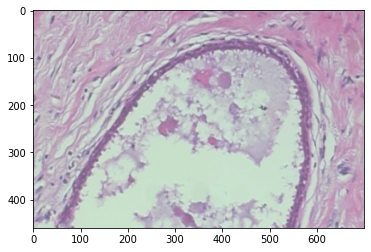

In [26]:
#show an image
image_path = '../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png'
image = Image.open(image_path)
print(image)
print(image.size)
print(image.mode)

plt.imshow(image)
plt.show()

Show the same image as before after preprocessing

torch.float32


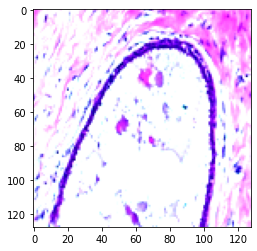

In [32]:
# Get the first image from the dataset
image = dataset[dataset.image_files.index("../BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png")]

print(image.dtype)
image = image.clip(0, 1)
# Show the image
plt.imshow(image.permute(1, 2, 0))
plt.show()

In [ ]:
#PROVA
'''
# Retrieve data and labels
for batch in dataloader:
    if 'train_data' not in locals():
        train_data = batch
    else:
        train_data = np.concatenate((train_data, batch), axis=0)  # Concatenare i batch successivi

# Verificare se train_data è definito prima di eseguire ulteriori operazioni
if 'train_data' in locals():
    # Data augmentation using SMOTE
    train_data = train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3).numpy()
    train_labels = np.array([0] * (len(train_data) // 2) + [1] * (len(train_data) // 2))  # Assuming binary classification
    sm = SMOTE(random_state=42)
    train_data, train_labels = sm.fit_resample(train_data, train_labels)

    train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
    print(train_data.shape, train_labels.shape) 
else:
    print("Il dataloader non ha restituito alcun batch.")
'''


'\n# Retrieve data and labels\nfor batch in dataloader:\n    if \'train_data\' not in locals():\n        train_data = batch\n    else:\n        train_data = np.concatenate((train_data, batch), axis=0)  # Concatenare i batch successivi\n\n# Verificare se train_data è definito prima di eseguire ulteriori operazioni\nif \'train_data\' in locals():\n    # Data augmentation using SMOTE\n    train_data = train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3).numpy()\n    train_labels = np.array([0] * (len(train_data) // 2) + [1] * (len(train_data) // 2))  # Assuming binary classification\n    sm = SMOTE(random_state=42)\n    train_data, train_labels = sm.fit_resample(train_data, train_labels)\n\n    train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)\n    print(train_data.shape, train_labels.shape) \nelse:\n    print("Il dataloader non ha restituito alcun batch.")\n'